In [ ]:
import pandas as pd
import numpy as np
import glob as glob
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn import metrics

In [ ]:
#path = "/gdrive/My Drive/Full Dataset/train test val split"
path = r"I:\.shortcut-targets-by-id\0Bz-k3GVdqSBHSUZDVFhiMzFBSXc\E\Columbia\GVN Lab\BeatProfiler\drug classification\data compilation\train test val split"
train = pd.read_csv(os.path.join(path, 'train_soft_summary.csv'), index_col=[0,1,2]).sort_index()
val = pd.read_csv(os.path.join(path, 'val_soft_summary.csv'), index_col=[0,1,2]).sort_index()
test = pd.read_csv(os.path.join(path, 'test_soft_summary.csv'), index_col=[0,1,2]).sort_index()

In [ ]:
train


index       drug class  num peaks  \
plate        row col                                                   
2021.08.19   A   1              Well 1_1       ctrl  ctrl       22.0   
                 3              Well 3_1       ctrl  ctrl       21.0   
                 5              Well 5_1  quinidine     I       23.0   
                 6              Well 6_1  quinidine     I       22.0   
                 8              Well 8_1  quinidine     I       38.0   
...                                  ...        ...   ...        ...   
2022.09.20_A F   10   Plate A\Well F10_1      E4031   III       11.0   
                 11   Plate A\Well F11_1  quinidine     I        7.0   
             G   3     Plate A\Well G3_1       ctrl  ctrl       11.0   
             H   1     Plate A\Well H1_1      E4031   III       30.0   
                 10   Plate A\Well H10_1      E4031   III       29.0   

                            bpm     RMSSD  mean RR interval  mean amplitude  \
plate        row col                                                          
2021.08.19   A   1    23.836549  2.523703          2.517143        0.201198   
                 3    23.112481  2.596245          2.596000        0.225356   
                 5    24.737631  2.438930          2.425455        0.321613   
                 6    23.666416  2.559462          2.535238        0.317464   
                 8    39.756447  1.509530          1.509189        0.268521   
...                         ...       ...               ...             ...   
2022.09.20_A F   10   39.551747  1.520779          1.517000        0.111382   
                 11   34.682081  1.737690          1.730000        0.121886   
             G   3    35.149385  1.714482          1.707000        0.109989   
             H   1    47.592998  1.267400          1.260690        0.106032   
                 10   52.190121  1.154957          1.149643        0.096315   

                      mean raw amplitude  mean auc  ...  std amplitude  \
plate        row col                                ...                  
2021.08.19   A   1             44.809517  0.104950  ...       0.001646   
                 3             49.254199  0.124119  ...       0.002418   
                 5             69.405072  0.234174  ...       0.004096   
                 6             70.394866  0.216999  ...       0.006169   
                 8             58.860964  0.157293  ...       0.004773   
...                                  ...       ...  ...            ...   
2022.09.20_A F   10            21.225932  0.072345  ...       0.001715   
                 11            23.502952  0.077804  ...       0.002585   
             G   3             20.771968  0.072219  ...       0.004586   
             H   1             20.032493  0.064943  ...       0.006963   
                 10            19.424231  0.050936  ...       0.004168   

                      std raw amplitude   std auc   std tau  std fwhm  \
plate        row col                                                    
2021.08.19   A   1             0.366526  0.001664  0.009470  0.008900   
                 3             0.528492  0.000633  0.009244  0.001697   
                 5             0.883912  0.005189  0.011895  0.006895   
                 6             1.368018  0.008620  0.014454  0.012933   
                 8             1.046243  0.002226  0.010539  0.002024   
...                                 ...       ...       ...       ...   
2022.09.20_A F   10            0.326795  0.002976  0.020529  0.017032   
                 11            0.498399  0.001873  0.010552  0.008342   
             G   3             0.866077  0.005026  0.029844  0.021711   
             H   1             1.315419  0.007262  0.023596  0.032235   
                 10            0.840503  0.004198  0.015496  0.012673   

                      std contract50  std relax50  std fw90m  std contract90  \
plate        row col                                                         

## Splitting Data

We gather all indices, only look at one timepoint (since it's paired), split the dataset, then match them back to dataframe.

In [ ]:
pd.concat([train.loc[:,"num peaks":],val.loc[:,"num peaks":]])

num peaks        bpm     RMSSD  mean RR interval  \
plate        row col                                                     
2021.08.19   A   1         22.0  23.836549  2.523703          2.517143   
                 3         21.0  23.112481  2.596245          2.596000   
                 5         23.0  24.737631  2.438930          2.425455   
                 6         22.0  23.666416  2.559462          2.535238   
                 8         38.0  39.756447  1.509530          1.509189   
...                         ...        ...       ...               ...   
2022.09.19_B F   9         16.0  34.735623  1.732680          1.727333   
             G   1         11.0  39.525692  1.552218          1.518000   
2022.09.20_A B   10        24.0  31.629613  1.914123          1.896957   
             D   10        32.0  38.928422  1.555204          1.541290   
             E   1         29.0  40.287770  1.498714          1.489286   

                      mean amplitude  mean raw amplitude  mean auc  mean tau  \
plate        row col                                                           
2021.08.19   A   1          0.201198           44.809517  0.104950  0.310498   
                 3          0.225356           49.254199  0.124119  0.325271   
                 5          0.321613           69.405072  0.234174  0.495161   
                 6          0.317464           70.394866  0.216999  0.444078   
                 8          0.268521           58.860964  0.157293  0.398743   
...                              ...                 ...       ...       ...   
2022.09.19_B F   9          0.110739           20.371320  0.079471  0.468080   
             G   1          0.134628           24.996730  0.077527  0.310681   
2022.09.20_A B   10         0.108969           20.198665  0.092202  0.643489   
             D   10         0.087621           16.502384  0.066787  0.540843   
             E   1          0.098694           18.479277  0.072418  0.515865   

                      mean fwhm  mean contract50  ...  std amplitude  \
plate        row col                              ...                  
2021.08.19   A   1     0.515690         0.262664  ...       0.001646   
                 3     0.535641         0.272496  ...       0.002418   
                 5     0.749051         0.321197  ...       0.004096   
                 6     0.696711         0.316568  ...       0.006169   
                 8     0.588133         0.249600  ...       0.004773   
...                         ...              ...  ...            ...   
2022.09.19_B F   9     0.734392         0.332095  ...       0.004062   
             G   1     0.573697         0.322405  ...       0.006034   
2022.09.20_A B   10    0.835953         0.343644  ...       0.004232   
             D   10    0.762227         0.330023  ...       0.004742   
             E   1     0.738483         0.316301  ...       0.005337   

                      std raw amplitude   std auc   std tau  std fwhm  \
plate        row col                                                    
2021.08.19   A   1             0.366526  0.001664  0.009470  0.008900   
                 3             0.528492  0.000633  0.009244  0.001697   
                 5             0.883912  0.005189  0.011895  0.006895   
                 6             1.368018  0.008620  0.014454  0.012933   
                 8             1.046243  0.002226  0.010539  0.002024   
...                                 ...       ...       ...       ...   
2022.09.19_B F   9             0.747195  0.008755  0.030633  0.034123   
             G   1             1.120305  0.006568  0.014452  0.025275   
2022.09.20_A B   10            0.784496  0.011484  0.097996  0.023119   
             D   10            0.893168  0.010325  0.094134  0.037977   
             E   1             0.999362  0.011901  0.086233  0.045084   

                      std contract50  std relax50  std fw90m  std contract90  \
plate        row col                               

In [ ]:
X_drug_train = train.loc[:,"num peaks":"std relax90"].drop(["mean raw amplitude", "std raw amplitude"], axis=1)
X_drug_test = test.loc[:,"num peaks":"std relax90"].drop(["mean raw amplitude", "std raw amplitude"], axis=1)


In [ ]:
y_drug_train = train['class']
y_drug_test = test['class']

In [ ]:
y_drug_train.head()

plate       row  col
2021.08.19  A    1      ctrl
                 3      ctrl
                 5         I
                 6         I
                 8         I
Name: class, dtype: object

We then extract X and y using the same split for the baseline data

In [ ]:

scaler = MinMaxScaler()
X_train_drug_only_scaled = pd.DataFrame(scaler.fit_transform(X_drug_train))
X_test_drug_only_scaled = pd.DataFrame(scaler.transform(X_drug_test))

# Visualize the dataset first

In [ ]:
X_drug_train.head()

num peaks        bpm     RMSSD  mean RR interval  \
plate      row col                                                     
2021.08.19 A   1         22.0  23.836549  2.523703          2.517143   
               3         21.0  23.112481  2.596245          2.596000   
               5         23.0  24.737631  2.438930          2.425455   
               6         22.0  23.666416  2.559462          2.535238   
               8         38.0  39.756447  1.509530          1.509189   

                    mean amplitude  mean auc  mean tau  mean fwhm  \
plate      row col                                                  
2021.08.19 A   1          0.201198  0.104950  0.310498   0.515690   
               3          0.225356  0.124119  0.325271   0.535641   
               5          0.321613  0.234174  0.495161   0.749051   
               6          0.317464  0.216999  0.444078   0.696711   
               8          0.268521  0.157293  0.398743   0.588133   

                    mean contract50  mean relax50  ...      SDRR  \
plate      row col                                 ...             
2021.08.19 A   1           0.262664      0.253026  ...  0.181846   
               3           0.272496      0.263144  ...  0.035693   
               5           0.321197      0.427854  ...  0.256031   
               6           0.316568      0.380143  ...  0.351305   
               8           0.249600      0.338533  ...  0.032079   

                    std amplitude   std auc   std tau  std fwhm  \
plate      row col                                                
2021.08.19 A   1         0.001646  0.001664  0.009470  0.008900   
               3         0.002418  0.000633  0.009244  0.001697   
               5         0.004096  0.005189  0.011895  0.006895   
               6         0.006169  0.008620  0.014454  0.012933   
               8         0.004773  0.002226  0.010539  0.002024   

                    std contract50  std relax50  std fw90m  std contract90  \
plate      row col                                                           
2021.08.19 A   1          0.011983     0.009547   0.013523        0.014589   
               3          0.010019     0.009537   0.005124        0.010056   
               5          0.011250     0.011885   0.013286        0.012543   
               6          0.014926     0.014446   0.021123        0.017668   
               8          0.010654     0.010444   0.004604        0.010736   

                    std relax90  
plate      row col               
2021.08.19 A   1       0.011385  
               3       0.011353  
               5       0.014004  
               6       0.015770  
               8       0.012056  

[5 rows x 23 columns]

# Export function

In [ ]:
def export_evaluate(y_true, y_pred, export):
    cfn_matrix_sample = confusion_matrix(y_true, y_pred)
    classes = ['I', 'II', 'III', 'IV', 'ctrl']

    os.makedirs(export, exist_ok=True)
    cfn_matrix_sample_frame = pd.DataFrame(cfn_matrix_sample, index=np.core.defchararray.add("True ",classes), columns=np.core.defchararray.add("Pred ",classes)).to_csv(os.path.join(export, "sample_confusion_matrix.csv"))
    pd.DataFrame(classification_report(y_true, y_pred, target_names=classes, output_dict=True)).T.to_csv(os.path.join(export, "sample_clsf_summary.csv"))
    wrong_index = pd.DataFrame()
    wrong_index['true'] = y_true
    wrong_index['pred'] = y_pred
    wrong_index['correct'] = np.array(y_true) == np.array(y_pred)
    wrong_index.to_csv(os.path.join(export, "misclassified.csv"))

# Models

Now we have 4 variables:

    X_drug_train, X_drug_test, y_drug_train, y_drug_test
    
    

# KNN

In [ ]:
knn = KNeighborsClassifier()
k = np.arange(20)*2+1
param_knn= [{'n_neighbors':k}]
knn_clf = GridSearchCV(knn, param_knn, cv=5)
knn_clf.fit(X_train_drug_only_scaled,y_drug_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39])}])

In [ ]:
knn_clf.best_params_

{'n_neighbors': 21}

In [ ]:
model_KNN = KNeighborsClassifier(n_neighbors=21)

# training
model_KNN.fit(X_train_drug_only_scaled,y_drug_train)

# prediction
predictions_KNN = model_KNN.predict(X_test_drug_only_scaled)

print(predictions_KNN)
# accuracy
print(accuracy_score(y_drug_test,predictions_KNN))

['ctrl' 'II' 'I' 'ctrl' 'III' 'ctrl' 'ctrl' 'II' 'III' 'II' 'II' 'ctrl'
 'I' 'IV' 'ctrl' 'ctrl' 'ctrl' 'ctrl' 'II' 'II' 'II' 'II' 'ctrl' 'ctrl'
 'ctrl' 'ctrl' 'ctrl' 'ctrl' 'ctrl' 'ctrl' 'II' 'II' 'II' 'II' 'ctrl' 'I'
 'ctrl' 'ctrl' 'ctrl' 'ctrl' 'ctrl' 'I' 'ctrl' 'I' 'ctrl' 'I' 'ctrl'
 'ctrl' 'ctrl' 'ctrl' 'ctrl' 'ctrl' 'I' 'I' 'ctrl' 'ctrl' 'III' 'III' 'II'
 'II' 'III' 'IV' 'IV' 'IV' 'IV' 'IV' 'IV' 'IV' 'IV' 'IV' 'ctrl' 'ctrl'
 'III' 'III' 'ctrl' 'III' 'III' 'III' 'III' 'ctrl' 'III' 'ctrl' 'ctrl'
 'ctrl' 'ctrl' 'I' 'III' 'III' 'ctrl' 'III' 'III' 'III' 'IV' 'IV' 'ctrl'
 'IV' 'II' 'II' 'IV' 'ctrl' 'I' 'ctrl' 'ctrl' 'I' 'ctrl' 'I' 'I' 'III' 'I'
 'I' 'I' 'III' 'ctrl' 'ctrl' 'ctrl' 'I' 'I' 'ctrl' 'I' 'I' 'III' 'IV'
 'III' 'II' 'II' 'ctrl' 'II' 'ctrl' 'IV' 'ctrl' 'II' 'II' 'ctrl' 'ctrl'
 'ctrl' 'ctrl' 'ctrl' 'ctrl' 'ctrl' 'ctrl' 'ctrl' 'ctrl' 'I' 'ctrl' 'ctrl'
 'ctrl' 'III' 'II' 'ctrl' 'I' 'ctrl' 'I' 'II' 'II' 'II' 'I' 'ctrl' 'III'
 'I' 'I' 'II' 'I' 'II' 'ctrl' 'I' 'ctrl' 'IV' 'IV' 'ctrl' 

In [ ]:
y_pred_train = model_KNN.predict(X_train_drug_only_scaled)
y_pred_test = model_KNN.predict(X_test_drug_only_scaled)

# metrics.confusion_matrix(y_drug_test, y_pred_test)
model_KNN.classes_

array(['I', 'II', 'III', 'IV', 'ctrl'], dtype=object)

<AxesSubplot: title={'center': 'Model: KNN'}>

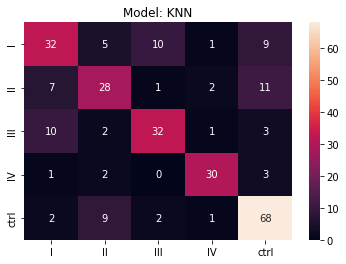

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cfn_matrix_knn = confusion_matrix(y_drug_test,predictions_KNN)

x_axis_labels = model_KNN.classes_
y_axis_labels = model_KNN.classes_


plt.title('Model: KNN')
sns.heatmap(cfn_matrix_knn, annot = True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)

In [ ]:
for i in range(1,6):
    folder_path = r"I:\.shortcut-targets-by-id\0Bz-k3GVdqSBHSUZDVFhiMzFBSXc\E\Columbia\GVN Lab\BeatProfiler\drug classification\traditional ml models"
    model_name = os.path.join(folder_path, "KNN_"+ str(i))
    model_KNN = KNeighborsClassifier(n_neighbors=21)
    # training
    model_KNN.fit(X_train_drug_only_scaled,y_drug_train)
    # prediction
    predictions_KNN = model_KNN.predict(X_test_drug_only_scaled)
    export_evaluate(y_drug_test,predictions_KNN,model_name)

# Lasso

In [ ]:
lasso = LogisticRegression(penalty='l1', solver="saga", max_iter=1000)
param_lasso = [{'C':[0.00001,0.0001,0.001,0.01,0.1,1,10,100]}]
lasso_clf1 = GridSearchCV(lasso, param_lasso, cv=5)
lasso_clf1.fit(X_train_drug_only_scaled,y_drug_train)

C:\Users\YBLab\Anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\YBLab\Anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\YBLab\Anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\YBLab\Anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\YBLab\Anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\YBLab\Anaconda3\envs\mlenv\lib\site-packages\s

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=1000, penalty='l1',
                                          solver='saga'),
             param_grid=[{'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}])

In [ ]:
lasso_clf1.best_params_

{'C': 10}

In [ ]:
drug_classifier = LogisticRegression(penalty='l1', solver="saga", C=10)

drug_classifier.fit(X_train_drug_only_scaled, y_drug_train)

C:\Users\YBLab\Anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=10, penalty='l1', solver='saga')

In [ ]:

y_pred = drug_classifier.predict(X_test_drug_only_scaled)


print("Accuracy:",accuracy_score(y_drug_test, y_pred))

Accuracy: 0.6948529411764706


In [ ]:
for i in range(1,6):
    folder_path = r"I:\.shortcut-targets-by-id\0Bz-k3GVdqSBHSUZDVFhiMzFBSXc\E\Columbia\GVN Lab\BeatProfiler\drug classification\traditional ml models"
    model_name = os.path.join(folder_path, "LASSO_"+ str(i))
    model = LogisticRegression(penalty='l1', solver="saga", C=1)
    # training
    model.fit(X_train_drug_only_scaled,y_drug_train)
    # prediction
    predictions = model.predict(X_test_drug_only_scaled)
    export_evaluate(y_drug_test,predictions,model_name)

C:\Users\YBLab\Anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\YBLab\Anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\YBLab\Anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\YBLab\Anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\YBLab\Anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

lreg_clf = LogisticRegression(multi_class='multinomial', solver='saga',max_iter=5000)

param_grid = {'C': [0.00001,0.0001,0.001,0.01,0.1,1,10,100], 'penalty': ['l1', 'l2']}

grid_search = GridSearchCV(lreg_clf, param_grid, cv=5, scoring= 'accuracy' ,return_train_score=True)
grid_search.fit(X_train_drug_only_scaled,y_drug_train)

C:\Users\YBLab\Anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\YBLab\Anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\YBLab\Anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=5000,
                                          multi_class='multinomial',
                                          solver='saga'),
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='accuracy')

In [ ]:
grid_search.best_params_


{'C': 10, 'penalty': 'l1'}

In [ ]:
lreg_clf= LogisticRegression(multi_class='multinomial', solver='saga', C=10, penalty= 'l1', max_iter=5000)
lreg_clf.fit(X_train_drug_only_scaled, y_drug_train)

LogisticRegression(C=10, max_iter=5000, multi_class='multinomial', penalty='l1',
                   solver='saga')

In [ ]:
y_pred_train = lreg_clf.predict(X_train_drug_only_scaled)
y_pred_test = lreg_clf.predict(X_test_drug_only_scaled)

lreg_train_accuracy_score = accuracy_score(y_drug_train, y_pred_train)
lreg_test_accuracy_score = accuracy_score(y_drug_test, y_pred_test)

print('Train Precision score: {}'
      .format(lreg_train_accuracy_score))
print('Test Precision score: {}'
      .format(lreg_test_accuracy_score))

Train Precision score: 0.6977848101265823
Test Precision score: 0.7022058823529411


<AxesSubplot: title={'center': 'Model: Logistic regression'}>

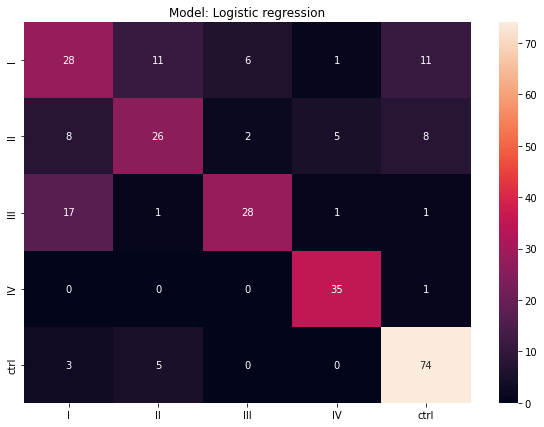

In [ ]:
predictions = lreg_clf.predict(X_test_drug_only_scaled)

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cfn_matrix_NB = confusion_matrix(y_drug_test,predictions)

x_axis_labels = ['I', 'II', 'III', 'IV', 'ctrl']
y_axis_labels = ['I', 'II', 'III', 'IV', 'ctrl']


plt.figure(figsize = (10,7))
plt.title('Model: Logistic regression')
sns.heatmap(cfn_matrix_NB, annot = True,  xticklabels=x_axis_labels, yticklabels=y_axis_labels)

In [ ]:
for i in range(1,6):
    folder_path = r"I:\.shortcut-targets-by-id\0Bz-k3GVdqSBHSUZDVFhiMzFBSXc\E\Columbia\GVN Lab\BeatProfiler\drug classification\traditional ml models"
    model_name = os.path.join(folder_path, "Multinomial_Logistic_Reg_"+ str(i))
    model = LogisticRegression(penalty='l1', solver="saga", C=10, max_iter=5000)
    # training
    model.fit(X_train_drug_only_scaled,y_drug_train)
    # prediction
    predictions = model.predict(X_test_drug_only_scaled)
    export_evaluate(y_drug_test,predictions,model_name)

# Naive Bayes

In [ ]:
model = GaussianNB()

# training
model.fit(X_train_drug_only_scaled,y_drug_train)

# prediction
predictions = model.predict(X_test_drug_only_scaled)

# accuracy
print(accuracy_score(y_drug_test,predictions))

0.4522058823529412


<AxesSubplot: title={'center': 'Model: NB'}>

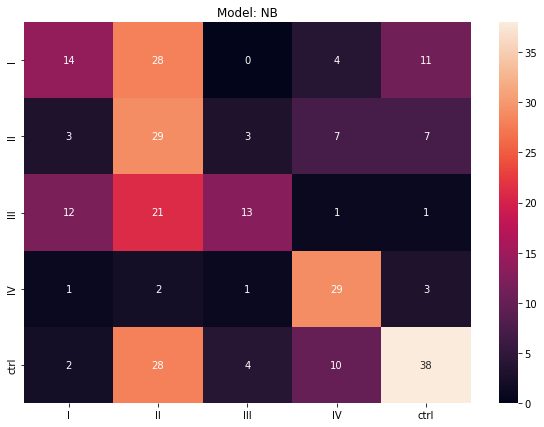

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cfn_matrix_NB = confusion_matrix(y_drug_test,predictions)

x_axis_labels =['I', 'II', 'III', 'IV', 'ctrl']
y_axis_labels = ['I', 'II', 'III', 'IV', 'ctrl']


plt.figure(figsize = (10,7))
plt.title('Model: NB')
sns.heatmap(cfn_matrix_NB, annot = True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)

In [ ]:
for i in range(1,6):
    folder_path = r"I:\.shortcut-targets-by-id\0Bz-k3GVdqSBHSUZDVFhiMzFBSXc\E\Columbia\GVN Lab\BeatProfiler\drug classification\traditional ml models"
    model_name = os.path.join(folder_path, "Naive_Bayes_"+ str(i))
    model = GaussianNB()
    # training
    model.fit(X_train_drug_only_scaled,y_drug_train)
    # prediction
    predictions = model.predict(X_test_drug_only_scaled)
    export_evaluate(y_drug_test,predictions,model_name)

# SVM

In [ ]:


%time
# defining parameter range
param_grid = {
              'C':[0.01, 0.02, 0.025, 0.1, 0.2, 0.5, 1, 2, 5, 10],
              'gamma':['scale', 'auto'],
              'kernel': ['linear', 'poly', 'rbf'],
              'decision_function_shape':['ovo', 'ovr']
              }

grid = GridSearchCV(SVC(cache_size=300), param_grid, refit = True, verbose = 4,n_jobs=-1,scoring='accuracy')

# fitting the model for grid search
grid.fit(X_train_drug_only_scaled,y_drug_train)

CPU times: total: 0 ns
Wall time: 0 ns
Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(estimator=SVC(cache_size=300), n_jobs=-1,
             param_grid={'C': [0.01, 0.02, 0.025, 0.1, 0.2, 0.5, 1, 2, 5, 10],
                         'decision_function_shape': ['ovo', 'ovr'],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf']},
             scoring='accuracy', verbose=4)

In [ ]:
print(grid.best_params_)

{'C': 2, 'decision_function_shape': 'ovo', 'gamma': 'scale', 'kernel': 'linear'}


In [ ]:
drug_classifier_final = SVC(kernel='linear', C=2, gamma = 'scale', decision_function_shape='ovo')

drug_classifier_final.fit(X_train_drug_only_scaled,y_drug_train)

SVC(C=2, decision_function_shape='ovo', kernel='linear')

In [ ]:
prediction = drug_classifier_final.predict(X_test_drug_only_scaled)

print("Accuracy:",metrics.accuracy_score(y_drug_test, prediction))
print(prediction)

Accuracy: 0.6507352941176471
['ctrl' 'ctrl' 'I' 'ctrl' 'I' 'II' 'II' 'ctrl' 'ctrl' 'II' 'ctrl' 'ctrl'
 'II' 'II' 'ctrl' 'ctrl' 'ctrl' 'ctrl' 'II' 'II' 'II' 'ctrl' 'ctrl' 'ctrl'
 'ctrl' 'ctrl' 'ctrl' 'ctrl' 'ctrl' 'ctrl' 'ctrl' 'ctrl' 'IV' 'IV' 'ctrl'
 'ctrl' 'ctrl' 'ctrl' 'ctrl' 'ctrl' 'ctrl' 'ctrl' 'ctrl' 'ctrl' 'ctrl'
 'ctrl' 'II' 'ctrl' 'ctrl' 'ctrl' 'ctrl' 'ctrl' 'I' 'I' 'ctrl' 'ctrl' 'I'
 'I' 'III' 'II' 'III' 'IV' 'IV' 'IV' 'IV' 'IV' 'IV' 'IV' 'IV' 'IV' 'ctrl'
 'ctrl' 'III' 'III' 'ctrl' 'III' 'III' 'III' 'III' 'ctrl' 'I' 'ctrl'
 'ctrl' 'ctrl' 'ctrl' 'I' 'III' 'III' 'ctrl' 'III' 'I' 'I' 'IV' 'IV'
 'ctrl' 'IV' 'II' 'I' 'IV' 'ctrl' 'ctrl' 'II' 'ctrl' 'ctrl' 'ctrl' 'I' 'I'
 'II' 'II' 'I' 'II' 'III' 'ctrl' 'ctrl' 'ctrl' 'I' 'II' 'ctrl' 'I' 'I'
 'III' 'IV' 'III' 'I' 'I' 'ctrl' 'I' 'ctrl' 'IV' 'III' 'I' 'I' 'ctrl' 'I'
 'ctrl' 'I' 'ctrl' 'ctrl' 'ctrl' 'ctrl' 'ctrl' 'ctrl' 'I' 'ctrl' 'ctrl'
 'ctrl' 'III' 'ctrl' 'ctrl' 'IV' 'ctrl' 'ctrl' 'IV' 'ctrl' 'II' 'ctrl'
 'IV' 'III' 'I' 'I' 'II' 'I' 

<AxesSubplot: title={'center': 'Model: SVM'}>

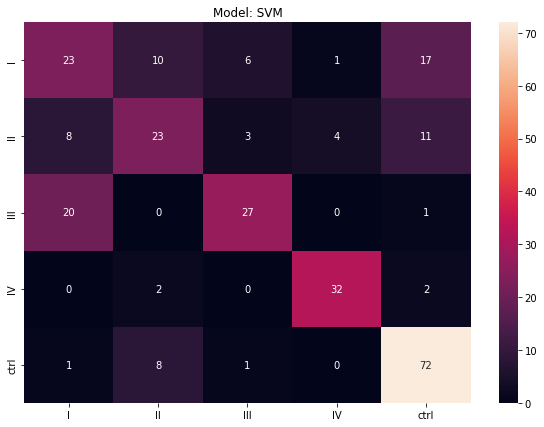

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cfn_matrix_svm = confusion_matrix(y_drug_test,prediction)

x_axis_labels = ['I', 'II', 'III', 'IV', 'ctrl']
y_axis_labels = ['I', 'II', 'III', 'IV', 'ctrl']


plt.figure(figsize = (10,7))
plt.title('Model: SVM')
sns.heatmap(cfn_matrix_svm, annot = True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)

In [ ]:
for i in range(1,6):
    folder_path = r"I:\.shortcut-targets-by-id\0Bz-k3GVdqSBHSUZDVFhiMzFBSXc\E\Columbia\GVN Lab\BeatProfiler\drug classification\traditional ml models"
    model_name = os.path.join(folder_path, "SVM_"+ str(i))
    model = SVC(kernel='linear', C=2, gamma = 'scale', decision_function_shape='ovo')
    # training
    model.fit(X_train_drug_only_scaled,y_drug_train)
    # prediction
    predictions = model.predict(X_test_drug_only_scaled)
    export_evaluate(y_drug_test,predictions,model_name)

# Decision tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier()

param_grid = {
            'criterion': ["gini", "entropy", "log_loss"],
            'max_depth': [5, 10, 20, 50, 100],
            'splitter': ['best', 'random'],
            'min_samples_split':[2,3,4,5,10,20,50],
            'max_features': ['sqrt', 'log2', None],
            }

grid_search_decision_tree = GridSearchCV(decision_tree, param_grid, cv = 5, return_train_score=True, verbose = 2, scoring = "accuracy", refit = True)
grid_search_decision_tree.fit(X_train_drug_only_scaled,y_drug_train)

Fitting 5 folds for each of 630 candidates, totalling 3150 fits
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth

[CV] END criterion=gini, max_depth=5, max_features=log2, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=log2, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=log2, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=log2, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=log2, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=log2, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=log2, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=log2, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=log2, min_samples_split=4, splitter=best; tot

[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=5, max_features=None, min_samples_split=5, splitter=best; t

[CV] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_split=20, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_split=20, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_split=20, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_split=20, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_split=20, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=sqrt, min_samples_split=20, sp

[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_split=50, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_split=50, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_split=50, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_split=50, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_split=50, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_split=50, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_split=50, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_split=50, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=10, max_features=log2, min_samples_split=50, sp

[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=sqrt, min_samples_split=3, splitte

[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=log2, min_samples_split=4, splitte

[CV] END criterion=gini, max_depth=20, max_features=None, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=None, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=None, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=None, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=None, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=None, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=None, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=None, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=20, max_features=None, min_samples_split=5, splitte

[CV] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=50, max_features=sqrt, min_samples_split=10, splitt

[CV] END criterion=gini, max_depth=50, max_features=log2, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=50, max_features=log2, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=50, max_features=log2, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=50, max_features=log2, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=50, max_features=log2, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=50, max_features=log2, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=50, max_features=log2, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=50, max_features=log2, min_samples_split=20, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=50, max_features=log2, min_samples_split=20

[CV] END criterion=gini, max_depth=50, max_features=None, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=50, max_features=None, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=50, max_features=None, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=50, max_features=None, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=50, max_features=None, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=50, max_features=None, min_samples_split=20, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=50, max_features=None, min_samples_split=20, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=50, max_features=None, min_samples_split=20, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=50, max_features=None, min_samples_split=20

[CV] END criterion=gini, max_depth=100, max_features=log2, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=100, max_features=log2, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=100, max_features=log2, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=100, max_features=log2, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=100, max_features=log2, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=100, max_features=log2, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=100, max_features=log2, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=100, max_features=log2, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=100, max_features=log2, min_samples_split=3

[CV] END criterion=gini, max_depth=100, max_features=None, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=100, max_features=None, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=100, max_features=None, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=100, max_features=None, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=100, max_features=None, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=gini, max_depth=100, max_features=None, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=100, max_features=None, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=100, max_features=None, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=gini, max_depth=100, max_features=None, min_samples_split=3, sp

[CV] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_features=sqrt, min_samples_sp

[CV] END criterion=entropy, max_depth=5, max_features=log2, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_features=log2, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_features=log2, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_features=log2, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_features=log2, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_features=log2, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_features=log2, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_features=log2, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_features=log2, min_sampl

[CV] END criterion=entropy, max_depth=5, max_features=None, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_features=None, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_features=None, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_features=None, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_features=None, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_features=None, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_features=None, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_features=None, min_samples_split=20, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=5, max_features=None, mi

[CV] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_split=20, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=sqrt, min_samples_split=20, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features

[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_split=50, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_split=50, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_split=50, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_split=50, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_split=50, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_split=50, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=log2, min_samples_split=50, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=None, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=

[CV] END criterion=entropy, max_depth=10, max_features=None, min_samples_split=50, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=None, min_samples_split=50, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=None, min_samples_split=50, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=10, max_features=None, min_samples_split=50, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=sqrt, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=sqrt, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=sqrt, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=sqrt, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=sqrt,

[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=log2, min_s

[CV] END criterion=entropy, max_depth=20, max_features=None, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=None, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=None, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=None, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=None, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=None, min_samples_split=4, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=None, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=None, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=20, max_features=None, m

[CV] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=50, max_features=sqrt, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=50, max_features=sqrt

[CV] END criterion=entropy, max_depth=50, max_features=log2, min_samples_split=20, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=50, max_features=log2, min_samples_split=20, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=50, max_features=log2, min_samples_split=20, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=50, max_features=log2, min_samples_split=50, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=50, max_features=log2, min_samples_split=50, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=50, max_features=log2, min_samples_split=50, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=50, max_features=log2, min_samples_split=50, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=50, max_features=log2, min_samples_split=50, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=50, max_features=log

[CV] END criterion=entropy, max_depth=50, max_features=None, min_samples_split=50, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=50, max_features=None, min_samples_split=50, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=50, max_features=None, min_samples_split=50, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=50, max_features=None, min_samples_split=50, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=50, max_features=None, min_samples_split=50, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=50, max_features=None, min_samples_split=50, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=50, max_features=None, min_samples_split=50, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=100, max_features=sqrt, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=100, max_feature

[CV] END criterion=entropy, max_depth=100, max_features=log2, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=100, max_features=log2, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=100, max_features=log2, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=100, max_features=log2, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=100, max_features=log2, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=100, max_features=log2, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=100, max_features=log2, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=100, max_features=log2, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=100, max_feature

[CV] END criterion=entropy, max_depth=100, max_features=None, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=100, max_features=None, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=100, max_features=None, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=100, max_features=None, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=100, max_features=None, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=100, max_features=None, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=100, max_features=None, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=entropy, max_depth=100, max_features=None, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=entropy, max_depth=100, max_feature

[CV] END criterion=log_loss, max_depth=5, max_features=sqrt, min_samples_split=5, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=5, max_features=sqrt, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=5, max_features=sqrt, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=5, max_features=sqrt, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=5, max_features=sqrt, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=5, max_features=sqrt, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=5, max_features=sqrt, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=5, max_features=sqrt, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=5, max_features=sqrt,

[CV] END criterion=log_loss, max_depth=5, max_features=log2, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=5, max_features=log2, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=5, max_features=log2, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=5, max_features=log2, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=5, max_features=log2, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=5, max_features=log2, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=5, max_features=log2, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=5, max_features=log2, min_samples_split=20, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=5, max_features

[CV] END criterion=log_loss, max_depth=5, max_features=None, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=5, max_features=None, min_samples_split=20, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=5, max_features=None, min_samples_split=20, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=5, max_features=None, min_samples_split=20, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=5, max_features=None, min_samples_split=20, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=5, max_features=None, min_samples_split=20, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=5, max_features=None, min_samples_split=20, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=5, max_features=None, min_samples_split=20, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=5, max_features=Non

[CV] END criterion=log_loss, max_depth=10, max_features=sqrt, min_samples_split=20, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=10, max_features=sqrt, min_samples_split=20, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=10, max_features=sqrt, min_samples_split=20, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=10, max_features=sqrt, min_samples_split=20, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=10, max_features=sqrt, min_samples_split=20, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=10, max_features=sqrt, min_samples_split=20, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=10, max_features=sqrt, min_samples_split=50, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=10, max_features=sqrt, min_samples_split=50, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=10, max

[CV] END criterion=log_loss, max_depth=10, max_features=None, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=10, max_features=None, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=10, max_features=None, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=10, max_features=None, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=10, max_features=None, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=10, max_features=None, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=10, max_features=None, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=10, max_features=None, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=10, max_feature

[CV] END criterion=log_loss, max_depth=20, max_features=sqrt, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=20, max_features=sqrt, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=20, max_features=sqrt, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=20, max_features=sqrt, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=20, max_features=sqrt, min_samples_split=3, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=20, max_features=sqrt, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=20, max_features=sqrt, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=20, max_features=sqrt, min_samples_split=4, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=20, max_feature

[CV] END criterion=log_loss, max_depth=20, max_features=log2, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=20, max_features=log2, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=20, max_features=log2, min_samples_split=5, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=20, max_features=log2, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=20, max_features=log2, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=20, max_features=log2, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=20, max_features=log2, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=20, max_features=log2, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=20, max_featur

[CV] END criterion=log_loss, max_depth=20, max_features=None, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=20, max_features=None, min_samples_split=10, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=20, max_features=None, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=20, max_features=None, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=20, max_features=None, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=20, max_features=None, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=20, max_features=None, min_samples_split=10, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=20, max_features=None, min_samples_split=20, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=20, max

[CV] END criterion=log_loss, max_depth=50, max_features=sqrt, min_samples_split=20, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=50, max_features=sqrt, min_samples_split=20, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=50, max_features=sqrt, min_samples_split=20, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=50, max_features=sqrt, min_samples_split=50, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=50, max_features=sqrt, min_samples_split=50, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=50, max_features=sqrt, min_samples_split=50, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=50, max_features=sqrt, min_samples_split=50, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=50, max_features=sqrt, min_samples_split=50, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=50, max_fea

[CV] END criterion=log_loss, max_depth=50, max_features=None, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=50, max_features=None, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=50, max_features=None, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=50, max_features=None, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=50, max_features=None, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=50, max_features=None, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=50, max_features=None, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=50, max_features=None, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=50, max_features=

[CV] END criterion=log_loss, max_depth=100, max_features=sqrt, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=100, max_features=sqrt, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=100, max_features=sqrt, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=100, max_features=sqrt, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=100, max_features=sqrt, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=100, max_features=sqrt, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=100, max_features=sqrt, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=100, max_features=sqrt, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=100, ma

[CV] END criterion=log_loss, max_depth=100, max_features=log2, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=100, max_features=log2, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=100, max_features=log2, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=100, max_features=log2, min_samples_split=2, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=100, max_features=log2, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=100, max_features=log2, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=100, max_features=log2, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=100, max_features=log2, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=100, max_

[CV] END criterion=log_loss, max_depth=100, max_features=None, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=100, max_features=None, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=100, max_features=None, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=100, max_features=None, min_samples_split=2, splitter=random; total time=   0.0s
[CV] END criterion=log_loss, max_depth=100, max_features=None, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=100, max_features=None, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=100, max_features=None, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=100, max_features=None, min_samples_split=3, splitter=best; total time=   0.0s
[CV] END criterion=log_loss, max_depth=100, max_

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [5, 10, 20, 50, 100],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_split': [2, 3, 4, 5, 10, 20, 50],
                         'splitter': ['best', 'random']},
             return_train_score=True, scoring='accuracy', verbose=2)

In [ ]:
print(grid_search_decision_tree.best_params_)

{'criterion': 'log_loss', 'max_depth': 5, 'max_features': None, 'min_samples_split': 4, 'splitter': 'random'}


In [ ]:
optimized_dt = DecisionTreeClassifier(criterion="log_loss",max_depth = 5, max_features = None, min_samples_split = 4, splitter = 'random')
optimized_dt.fit(X_train_drug_only_scaled,y_drug_train)

print('Train score: ', optimized_dt.score(X_train_drug_only_scaled,y_drug_train))
print('Test score: ', optimized_dt.score(X_test_drug_only_scaled, y_drug_test))

Train score:  0.6131329113924051
Test score:  0.5330882352941176


<AxesSubplot: title={'center': 'Model: Decision tree'}>

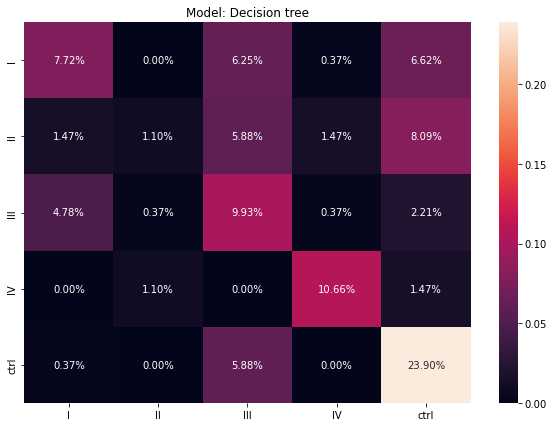

In [ ]:
predictions_dt = optimized_dt.predict(X_test_drug_only_scaled)

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cfn_matrix_dt = confusion_matrix(y_drug_test,predictions_dt)


plt.figure(figsize = (10,7))
plt.title('Model: Decision tree')
sns.heatmap(cfn_matrix_dt/np.sum(cfn_matrix_dt), annot = True, fmt='.2%', xticklabels=x_axis_labels, yticklabels=y_axis_labels)

In [ ]:
for i in range(1,6):
    folder_path = r"I:\.shortcut-targets-by-id\0Bz-k3GVdqSBHSUZDVFhiMzFBSXc\E\Columbia\GVN Lab\BeatProfiler\drug classification\traditional ml models"
    model_name = os.path.join(folder_path, "Decision_tree_"+ str(i))
    model = DecisionTreeClassifier(criterion="log_loss",max_depth = 5, max_features = None, min_samples_split = 4, splitter = 'random')
    # training
    model.fit(X_train_drug_only_scaled,y_drug_train)
    # prediction
    predictions = model.predict(X_test_drug_only_scaled)
    export_evaluate(y_drug_test,predictions,model_name)

# Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=0)

param_grid ={
          'max_depth': [5,10,15,20,25],
           'n_estimators':[100,200,300,400,500]}

grid_search = GridSearchCV(rf_clf, param_grid,cv=5, scoring='accuracy', n_jobs=-1,return_train_score=True)
grid_search.fit(X_train_drug_only_scaled,y_drug_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20, 25],
                         'n_estimators': [100, 200, 300, 400, 500]},
             return_train_score=True, scoring='accuracy')

In [ ]:
grid_search.best_params_

{'max_depth': 25, 'n_estimators': 400}

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=400, max_depth=25)
rf_clf.fit(X_train_drug_only_scaled, y_drug_train)

RandomForestClassifier(max_depth=25, n_estimators=400)

In [ ]:
from sklearn.metrics import accuracy_score

y_pred_train = rf_clf.predict(X_train_drug_only_scaled)
y_pred_test = rf_clf.predict(X_test_drug_only_scaled)

rf_train_accuracy_score = accuracy_score(y_drug_train, y_pred_train)
rf_test_accuracy_score = accuracy_score(y_drug_test, y_pred_test)

print('Train Precision score: {}'
      .format(rf_train_accuracy_score))
print('Test Precision score: {}'
      .format(rf_test_accuracy_score))


Train Precision score: 1.0
Test Precision score: 0.7683823529411765


<AxesSubplot: title={'center': 'Model: Random forest'}>

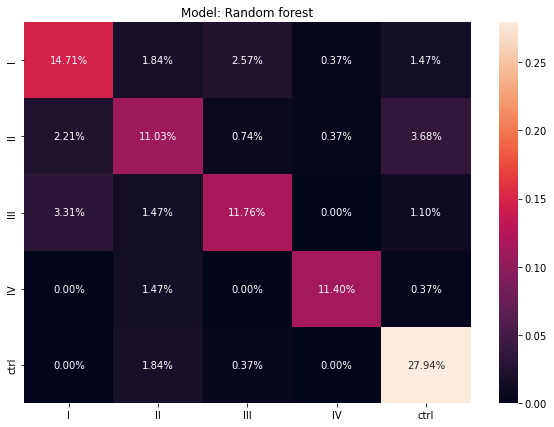

In [ ]:
predictions_rf = rf_clf.predict(X_test_drug_only_scaled)

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cfn_matrix_rf = confusion_matrix(y_drug_test,predictions_rf)


plt.figure(figsize = (10,7))
plt.title('Model: Random forest')
sns.heatmap(cfn_matrix_rf/np.sum(cfn_matrix_rf), annot = True, fmt='.2%', xticklabels=x_axis_labels, yticklabels=y_axis_labels)

In [ ]:
for i in range(1,6):
    folder_path = r"I:\.shortcut-targets-by-id\0Bz-k3GVdqSBHSUZDVFhiMzFBSXc\E\Columbia\GVN Lab\BeatProfiler\drug classification\traditional ml models"
    model_name = os.path.join(folder_path, "Random_forest_"+ str(i))
    model = RandomForestClassifier(n_estimators=400, max_depth=25)
    # training
    model.fit(X_train_drug_only_scaled,y_drug_train)
    # prediction
    predictions = model.predict(X_test_drug_only_scaled)
    export_evaluate(y_drug_test,predictions,model_name)